In [4]:
# We Import two libraries(one standard and one third-party) needed for performing the linear algebraic manipulations  
# and the random initialization of the main variables(weights and biases). Finally, we make
# use of the matplotlib library for monitoring the performance of the model and in turn selecting the adequate parameters.
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# The folowing neural network algorithm is built for classifying hand-written digits extracted from the widely known 
# MNIST dataset. This dataset contains a training, validation and test data totally comprised of 80.000 handwritten
# digits that we aim to classify using Stochastic Gradient Descent and Backpropagation for making the changes in the 
# parameters as controllable as possible and the sigmoid function for deciding the activation or not of a neuron. 
# Lots of details are given along the construction of the model below.

class Network():
    
    # Here we initialize the weights betwween the input layer and the first hidden layer of the network.
    # Also we initialize the biases that the neurons in the first hidden layer of the network have. Note that 
    # the input layer has no biases.
    # Finally sizes is a list indicating the number of neurons each layer has and so the length of the list
    # determines the number of network's layers.
    def __init__(self, sizes):
        self.n_max_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(x,1) for x in sizes[1:]]
        self.weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
    
    
    # To take the result of a single neuron based on sigmoid function (To get one prediction for the input a). 
    # Observe that this function updates the input value a as many times as the layers that we have, since
    # zip(self.biases,self.weights) contains one tuple for each layer, having the biases as the first component
    # and the respective weights from the previous to the following layer.
    def feed_forward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w,a)+b)
        return a
        
    # Stochastic Gradient Descent(the process is using backprop function(Backpropagation) which performs the gradient 
    # finding and will be explained afterwards). We use Stochastic gradient descent and not typical gradient decent in order to 
    # balance the trade-off between the large training data and the time needed to train the model.Namely, we partition the 
    # (shuffled)training data in mini batches and then we train the algorithm on each one of them separately. 
    # In terms of the variables, epochs variable determines how many times the training data will be partioned into mini batches.
    # Moreover, eta is the learning rate used for the gradient descent where here is performed by update_mini_batch
    # which gives the updated position of the the weights and biases towards the minimization of the 
    # cost function under consideration(the Quadratic Cost on this occasion).
    def SGD(self,training_data, mini_batch_size, epochs, eta, test_data = None):
        if test_data: n_test = len(test_data)
        n = len(training_data)    
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size] 
                for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ('Epoch{0}: {1}/{2}'.format(
                    j,self.evaluate(test_data),n_test))
            else:
                print ('Epoch{0}: Complete'.format(j))
     
    
    # The following function serves as a gradient descent iterator for all the training data contained in a mini-batch.
    # Actually what it does is that it first collects all the partial derivatives of the cost function with respect to 
    # biases and weights for all the train data inside the mini batch using backpropagation and finally updates the biases 
    # and weights by performing a gradient descent based on the given learning rate(eta).
    def update_mini_batch(self,mini_batch,eta):
        gradient_w = [np.zeros(w.shape) for w in self.weights]
        gradient_b = [np.zeros(b.shape) for b in self.biases]
        for x,y in mini_batch:
            delta_gd_w , delta_gd_b = self.backprop(x,y)
            gradient_w = [gd_w+dgd_w for gd_w, dgd_w in zip(gradient_w, delta_gd_w)]
            gradient_b = [gd_b+dgd_b for gd_b, dgd_b in zip(gradient_b, delta_gd_b)]
        self.weights = [w - (eta/len(mini_batch))*gd_w for w, gd_w in zip(self.weights, gradient_w)]
        self.biases = [b - (eta/len(mini_batch))*gd_b for b, gd_b in zip(self.biases, gradient_b)]
    
    # Backpropagation is method allowing us to determine the partial derivatives of the cost function with respect to 
    # weights and biases. Here, the function takes on a single training data point (x,y) as an input.
    def backprop(self,x,y):
        gradient_b = [np.zeros(b.shape) for b in self.biases]# Collection of Partial Derivative of the cost function with respect to b(bias)
        gradient_w = [np.zeros(w.shape) for w in self.weights]# Collection of Partial Derivative of the cost function with respect to w(weights)
        activation = x #Input is by default the first activation value
        activations = [x]# Here we will collect all the activations
        zs = []# To collect the z_values given in turn to the sigmoid function as input. 
        for b,w in zip(self.biases, self.weights):
            z = np.dot(w,activation) +  b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        delta = (activations[-1] - y) * sigmoid_prime(zs[-1])
        gradient_b[-1] = delta
        gradient_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.n_max_layers):
            delta = np.dot(self.weights[-l+1].transpose(),gradient_b[-l+1]) * sigmoid_prime(zs[-l])
            gradient_b[-l] = delta
            gradient_w[-l] = np.dot(delta,activations[-l-1].transpose())
        return (gradient_w, gradient_b)
    
   
    # A fuction calculating the correct model predictions on the train data, if provided. The predictions are based on the 
    # highest value given by the sigmoid function between the neurons in the output layer.
    def evaluate(self,test_data):
        test_results = [(np.argmax(self.feed_forward(x)),y)
                       for x,y in test_data]
        return sum(int(x==y) for x,y in test_results)
            

# The sigmoid function used for the decision making of the neurons taking as input a variable of the form z = Σw*x + b, where w 
# represents the weights, x the input values and b the bias.
def sigmoid(z):
        return 1.0/(1.0 + np.exp(-z))
    
# The Derivative of the sigmoid function
def sigmoid_prime(z):
        return (sigmoid(z) * (1 - sigmoid(z)))
        

In [7]:
# The following three functions are used for loading the dataset under investigation(MNIST) in an appropriate format.
# Firstly we load the dataset using the load_data function and then we create the load_data_wrapper for mainly 
# turn all inputs into (784,1) matrices since the inputs are 28x28(pixels)images. Moreover, in the training data we turn 
# the actual hand-written digits(y) into a binary vector
import gzip
import pickle

def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    train, val, test = u.load()
    return (train, val, test)

def load_data_wrapper():
    tr,val,test = load_data()
    tr_1 = [x.reshape(784,1) for x in tr[0]]
    tr_2 = [vectorize(y) for y in tr[1]]
    training_data = zip(tr_1, tr_2)
    training_data_fixed = [x for x in training_data]
    val_1 = [x.reshape(784,1) for x in val[0]]
    validation_data = zip(val_1, val[1])
    validation_data_fixed = [x for x in validation_data]
    tst_1 = [x.reshape(784,1) for x in test[0]]
    test_data = zip(tst_1, test[1])
    test_data_fixed = [x for x in test_data]
    return (training_data_fixed, validation_data_fixed, test_data_fixed)

def vectorize(y):
    e = np.zeros((10,1))
    e[y] = 1.0
    return e   

training_data, validation_data, test_data = load_data_wrapper()



In [359]:
# Now, we are ready to perform the model and take an account of its classification success rate for different parameters.
# Note that, the neural network begins with 784 neurons in the input layer and 10 neurons in the ouput layer to be in line 
# with the (modified)structure of the dataset. 

net = Network([784,30,10])

net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta = 0.5, test_data = validation_data)

Epoch0: 6973/10000
Epoch1: 8470/10000
Epoch2: 8774/10000
Epoch3: 8930/10000
Epoch4: 9016/10000
Epoch5: 9072/10000
Epoch6: 9108/10000
Epoch7: 9131/10000
Epoch8: 9174/10000
Epoch9: 9179/10000
Epoch10: 9212/10000
Epoch11: 9228/10000
Epoch12: 9245/10000
Epoch13: 9245/10000
Epoch14: 9268/10000
Epoch15: 9281/10000
Epoch16: 9280/10000
Epoch17: 9279/10000
Epoch18: 9300/10000
Epoch19: 9315/10000
Epoch20: 9318/10000
Epoch21: 9322/10000
Epoch22: 9314/10000
Epoch23: 9335/10000
Epoch24: 9344/10000
Epoch25: 9354/10000
Epoch26: 9342/10000
Epoch27: 9356/10000
Epoch28: 9353/10000
Epoch29: 9367/10000


In [17]:
# Now, we introduce the following three modifications to the built neural net above aiming to ameliorate its performance.  

# Backpropagation with the Cross_Entropy as the cost function. Cross-Entropy function allow the network to overcome 
# learning slowdowns. In practice, the rate of change of the cost function is not dependent on the derivative of the 
# sigmoid function which is responsible for the learning slowdown when the input values are close to either 0 or 1.
# Lets state here the definition of the cross-entropy function: C(a) -1/nΣ_{x}(ylna(a) + (1-y)ln(1-a)), where y(=y(x)) is
# the actual value, a(x) represents the outcome of the sigmoid function and the sum is taken over the training inputs x
# which are n in total.

# L1 and L2 Regulizations for ameliorating classification accuracy and reducing overfitting in neural nets. In both occasions 
# we add an extra component in the cost function which tries to keep weights magnitude low, or in other words to make the total
# net less dependent on individual piece of evidence. Another Regulatory technique for neural nets is the Drop-Out Method. For 
# now we are going to focus on L2 and L1 regularizations and in the following we try to include them inside a new neural net.
# Also, we will incorporate the cost function used in the model as a class variable with two methods(quadratic cost and cross
# entropy). 
 
# Finally  we take care of the weights and biases initialization. Namely, we try to keep the distribution of the the variable
# Σw*x + b, where w are the weights, x the input values and b the biases, as close to Gaussian(0,1) as possible. Loosely speaking, 
# if the input values were either 0 or 1 then we only need to control the variance of the weights and to do so we divide 
# we divide each weight variable with the square root of the amount of weights.

class initialize():
    
    def random_initialize(sizes):
        biases = [np.random.randn(x,1) for x in sizes[1:]]
        weights = [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
        return (biases, weights)
    
    def standarised_initialize(sizes):
        biases = [np.random.randn(x,1) for x in sizes[1:]]
        weights = [np.random.randn(y,x)/np.sqrt(x) for x,y in zip(sizes[:-1],sizes[1:])]
        return (biases,weights)

class QuadraticCost():
    
    def fun(a,y):
        return (1/2)*np.linalg.norm(y-a)^2
    
    def delta(z,a,y):
        return (a-y)*sigmoid_prime(a)
    
class cross_entropy():
    
    def fun(a,y):
        return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))
    
    def delta(z,a,y):
        return (a-y)
    



# In the following neural net, except from adding new techniques that were described above, we create flags in the
# Stochastic Gradient Descent function, indicating which metric results for the model we want to generate and in turn
# enabling the plotting of these results for many different model (hyper-)parameters as shown in the following steps. 

class Network1():
    
    # Here we initialize the weights betwween the input layer and the first hidden layer of the network.
    # Also we initialize the biases that the neurons in the first hidden layer of the network have. Note that 
    # the input layer has no biases, and thats why start with 1 to be the first index used from sizes.
    # Finally sizes is a list indicating the number of neurons each layer has and in turn the length of the list
    # determines the number of network's layers.
    def __init__(self,sizes,cost = cross_entropy):
        self.n_max_layers = len(sizes)
        self.sizes = sizes
        self.cost = cost
        self.biases, self.weights = initialize.standarised_initialize(sizes) 

    
    # To take the result of a single neuron based on sigmoid function (To get one prediction for the input a) 
    # Observe that this function updates the input value (a) as many times as the layers that we have, since
    # zip(self.biases,self.weights) contains one tuple for each layer, having the biases as the first component
    # and the respective weights from the previous layer to the following one.
    def feed_forward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w,a)+b)
        return a
        
    # Stochastic Gradient Descent(the process is using backprop function(Backpropagation) which performs the gradient 
    # finding and will be explained afterwards). We use Stochastic gradient descent in order to balance the trade-off 
    # between the large training data and the time needed to train the model.Namely, we partition the (shuffled)training 
    # data in mini batches and then we train the algorithm on each one of them separately. 
    # In terms of the variables, epochs variable determines how many times the training data will be partioned into mini batches.
    # Moreover, eta is the learning rate used for the gradient descent where here is performed by update_mini_batch
    # which gives the updated position of the input(based on the weights and biases) towards the minimization of the 
    # cost function under consideration(MSE on this occasion).
    def SGD(self,training_data, mini_batch_size, epochs, eta,lmbd,
            monitor_training_cost = False,
            monitor_training_accuracy = False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            plot_accuracy = False,
            plot_cost = False,
            hyper_training_cost_plot = False,# The term 'hyper' is uded to indicate that these variables are for plots for hyperparameters determination 
            hyper_training_accuracy_plot = False,
            hyper_evaluation_cost_plot = False,
            hyper_evaluation_accuracy_plot = False,
            evaluation_data = None):
        training_cost = []
        training_accuracy = []
        evaluation_cost = []
        evaluation_accuracy = []
        if evaluation_data: n_evaluation = len(evaluation_data)
        n = len(training_data) 
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size] 
                for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbd,n)
            if monitor_training_cost:
                cost = self.total_cost(training_data,lmbd, convert = False)
                training_cost.append(cost)
                #print ("Cost on training data-Epoch{}: {} ".format(j,
                    #cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert = True)
                training_accuracy.append(accuracy)
                #print ("Accuracy on training data-Epoch{}: {} / {}".format(j,
                    #accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data,lmbd,convert = False)
                evaluation_cost.append(cost)
                #print ("Cost on evaluation data-Epoch{}: {} ".format(j,
                    #cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data,convert = False)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data-Epoch{}: {} / {}".format(j,
                    accuracy, n_evaluation))
            '''''    
            if evaluation_data:
                n_evaluation = len(evaluation_data)
                print ('Epoch{0}: {1}/{2}'.format(
                    j,self.evaluate(evaluation_data),n_evaluation))
            else:
                print ('Epoch{0}: Complete'.format(j))
            '''''
        if plot_accuracy:
            fig,ax = plt.subplots(figsize = (12,8))
            ax.plot([int(x) for x in range(epochs)], [x/n_evaluation for x in evaluation_accuracy],
                   label = 'Evaluation Accuracy', color = 'red')
            ax.plot([int(x) for x in range(epochs)], [x/n for x in training_accuracy], 
                    label = 'Training Accuracy', color = 'yellow')
            ax.legend(loc = 0)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Accuracy')
            plt.xticks(list(range(epochs)),range(epochs))
            plt.plot()
        if plot_cost:
            fig,ax = plt.subplots(figsize = (12,9))
            fig1, ax1 = plt.subplots(figsize = (12,9))
            ax.plot([int(x) for x in range(epochs)], [x for x in evaluation_cost], label = 'Evaluation Cost', color = 'red')
            ax1.plot([int(x) for x in range(epochs)], [x for x in training_cost], label = 'Training Cost',color = 'yellow')
            ax.legend(loc = 0)
            ax.set_xlabel('Epochs', weight = 'bold')
            ax.set_ylabel('Cost', weight = 'bold')
            ax.set_title('Validation data', weight = 'bold')
            ax1.legend(loc = 0)
            ax1.set_xlabel('Epochs', weight = 'bold')
            ax1.set_ylabel('Cost', weight = 'bold')
            ax1.set_title('Training data', weight = 'bold')
            plt.plot()
        if hyper_training_cost_plot:
            return training_cost
        if hyper_training_accuracy_plot:
            return training_accuracy
        if hyper_evaluation_accuracy_plot:
            return evaluation_accuracy
        if hyper_evaluation_cost_plot:
            return evaluation_cost
                
     
    
    # The difference in updating the weights and the biases to the previous model is that now we aslo
    # add the regularization term 'lmbd'.
    def update_mini_batch(self,mini_batch,eta,lmbd,n):
        gradient_w = [np.zeros(w.shape) for w in self.weights]
        gradient_b = [np.zeros(b.shape) for b in self.biases]
        for x,y in mini_batch:
            delta_gd_w , delta_gd_b = self.backprop(x,y)
            gradient_w = [gd_w+dgd_w for gd_w, dgd_w in zip(gradient_w, delta_gd_w)]
            gradient_b = [gd_b+dgd_b for gd_b, dgd_b in zip(gradient_b, delta_gd_b)]
        # Here is where L2-Regularization comes into play
        #self.weights = [w - (eta/len(mini_batch))*gd_w - (eta*lmbd*np.sign(w))/n for w, gd_w in zip(self.weights, gradient_w)]# L1 Regularization
        self.weights = [w - (eta/len(mini_batch))*gd_w - (eta*lmbd*w)/n for w, gd_w in zip(self.weights, gradient_w)]# L2 Regularization
        self.biases = [b - (eta/len(mini_batch))*gd_b for b, gd_b in zip(self.biases, gradient_b)]
    
    # Again the backrpropagation method with adjusted delta value based on whether the cost function is the Quadratic or the 
    # Cross-Entropy.
    def backprop(self,x,y):
        gradient_b = [np.zeros(b.shape) for b in self.biases]# Collection of Partial Derivative of the cost function with respect to b(bias)
        gradient_w = [np.zeros(w.shape) for w in self.weights]# Collection of Partial Derivative of the cost function with respect to w(weights)
        activation = x #Input is by default the first activation value
        activations = [x]# Here we will collect all the neuron activation values.
        zs = []# To collect the z_values given in turn to the sigmoid function as input. 
        for b,w in zip(self.biases, self.weights):
            z = np.dot(w,activation) +  b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        delta = self.cost.delta(z,activations[-1],y) 
        gradient_b[-1] = delta
        gradient_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.n_max_layers):
            delta = np.dot(self.weights[-l+1].transpose(),gradient_b[-l+1]) * sigmoid_prime(zs[-l])
            gradient_b[-l] = delta
            gradient_w[-l] = np.dot(delta,activations[-l-1].transpose())
        return (gradient_w, gradient_b)
      
    
    # Nothing changes in the way the model evaluates itself.
    def evaluate(self,test_data):
        test_results = [(np.argmax(self.feed_forward(x)),y)
                       for x,y in test_data]
        return sum(int(x==y) for x,y in test_results)
    
    # This is a new a function calculating the total cost of the model for a given dataset. Note that at the end 
    # we add the regulaziation terms.
    def total_cost(self,data,lmbd,convert):
        cost = 0
        for x,y in data:
            a = self.feed_forward(x)
            if convert: y = vectorize(y)
            cost += self.cost.fun(a,y)/len(data)
        #cost += (lmbd/len(data))*sum(np.linalg.norm(w) for w in self.weights)# L1 Regularization
        cost += 0.5*(lmbd/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # L2 Regularization
        return cost
    
    
    # An expansion of the evaluation function for performing two results collections based 
    # on whether is the training or validation(or test) set to be used. .
    def accuracy(self,data,convert):
        results = []
        for x,y in data:
            a = self.feed_forward(x)
            if convert: 
                results.append((np.argmax(a),np.argmax(y)))
            else:
                results.append((np.argmax(a),y))
        return sum(int(x == y) for x,y in results)
            

def sigmoid(z):
        return 1.0/(1.0 + np.exp(-z))
    

def sigmoid_prime(z):
        return (sigmoid(z) * (1 - sigmoid(z)))
        
   
    

In [18]:
# Soft-max function instead of the sigmoid function for neutrons decision making. The attractive part of this function 
# is that the sum of its outcome for all input values equals one. Therefore, it can be seen as the Probablity density function
# for the neutrons in the output layer. Namely, we could think of it as counting the probability that our estimation based on 
# the input value belongs to one of the neutrons(or activates the neutron). Then, the above obervation, affirms that the 
# probablility of the any neutrons activation is 1. If we also employ the negative lof of the softmax function as a cost 
# function, then the backpropagation delta parameter is identical to the one obtained by using the cross-entropy as a cost 
# function, as above.

def softmax(z):
    return np.exp(z)/sum(np.exp(z))

def log_cost(a):
    return -np.log(a)


array([-0.        , -0.        , -0.69314718, 75.98530807])

In [397]:
# Let us now run the model and check its accuracy on the training set. The model we build here has two 
# differences to the initial neural net above. In fact, the cost function is taken to be the cross entropy and not the 
# Quadratic cost and the initialization of weights and biases is standarized and not random as explained earlier.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta =  0.5, lmbd = 0,
            monitor_training_cost = False,
            monitor_training_accuracy =True,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            evaluation_data = validation_data)

Accuracy on training data-Epoch0: 46472 / 50000
Accuracy on training data-Epoch1: 47529 / 50000
Accuracy on training data-Epoch2: 47978 / 50000
Accuracy on training data-Epoch3: 48192 / 50000
Accuracy on training data-Epoch4: 48205 / 50000
Accuracy on training data-Epoch5: 48385 / 50000
Accuracy on training data-Epoch6: 48258 / 50000
Accuracy on training data-Epoch7: 48502 / 50000
Accuracy on training data-Epoch8: 48427 / 50000
Accuracy on training data-Epoch9: 48607 / 50000
Accuracy on training data-Epoch10: 48740 / 50000
Accuracy on training data-Epoch11: 48721 / 50000
Accuracy on training data-Epoch12: 48812 / 50000
Accuracy on training data-Epoch13: 48883 / 50000
Accuracy on training data-Epoch14: 48890 / 50000
Accuracy on training data-Epoch15: 48934 / 50000
Accuracy on training data-Epoch16: 48887 / 50000
Accuracy on training data-Epoch17: 49058 / 50000
Accuracy on training data-Epoch18: 48979 / 50000
Accuracy on training data-Epoch19: 49000 / 50000
Accuracy on training data-Epoc

In [363]:
# We do the same but now we measure the accuracy on the validation set.
# We can see that the Classification Success Rate becomes siginificantly better than it was with the Quadratic Cost
# (from 9367/1000 to 9667/1000). However we can see that the model now reached high percentage accuracy from a very ealy on, and 
# from epoch 5 onwards the improvement was not really significant. 
# Also, compared to the training set above here there is no gradual increase and the results are fluctuating around 96%. 
# These facts imply possible overfitting of the neural net that we will try to tackle by an L2 regularization term in the
# cost function. 

# In the following steps, we generate plots of model accuracy and cost function on the training and validation set.

net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta =  0.5, lmbd = 0,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = validation_data)

Accuracy on evaluation data: 9387 / 10000
Accuracy on evaluation data: 9514 / 10000
Accuracy on evaluation data: 9511 / 10000
Accuracy on evaluation data: 9594 / 10000
Accuracy on evaluation data: 9622 / 10000
Accuracy on evaluation data: 9622 / 10000
Accuracy on evaluation data: 9643 / 10000
Accuracy on evaluation data: 9624 / 10000
Accuracy on evaluation data: 9514 / 10000
Accuracy on evaluation data: 9636 / 10000
Accuracy on evaluation data: 9654 / 10000
Accuracy on evaluation data: 9634 / 10000
Accuracy on evaluation data: 9645 / 10000
Accuracy on evaluation data: 9648 / 10000
Accuracy on evaluation data: 9649 / 10000
Accuracy on evaluation data: 9639 / 10000
Accuracy on evaluation data: 9659 / 10000
Accuracy on evaluation data: 9661 / 10000
Accuracy on evaluation data: 9662 / 10000
Accuracy on evaluation data: 9631 / 10000
Accuracy on evaluation data: 9633 / 10000
Accuracy on evaluation data: 9618 / 10000
Accuracy on evaluation data: 9667 / 10000
Accuracy on evaluation data: 9665 

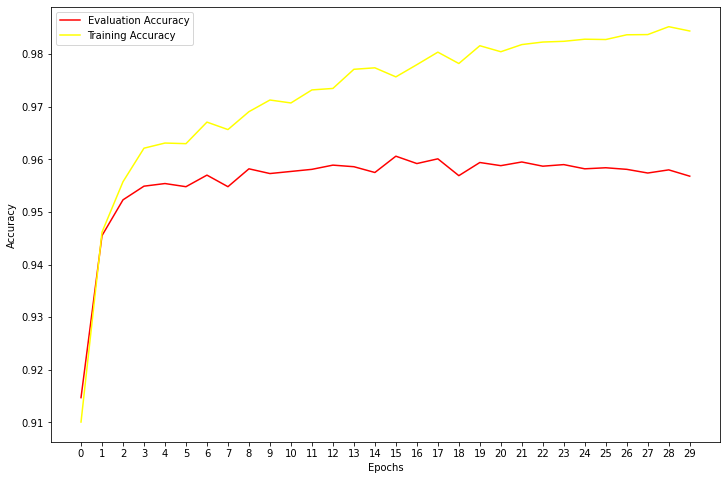

In [485]:
# Below is the plot of the above calculations, which shows that the discrepancy between the training and validation accuracy
# tend to increase as the epochs are passing.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta =  0.5, lmbd = 0,
            monitor_training_cost = True,
            monitor_training_accuracy =True,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            plot_accuracy = True,
            evaluation_data = validation_data)

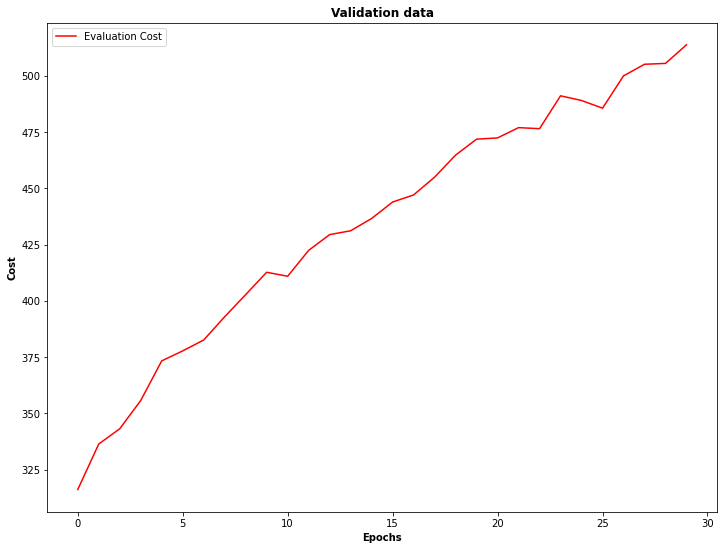

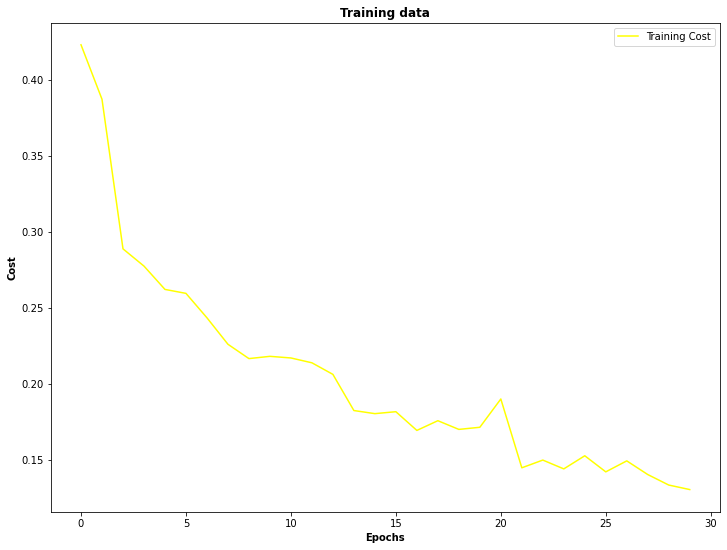

In [467]:
# We also plot the progress of cost function from epoch to epoch both on training and validation data. From the cost plot on 
# training data, we can see that there is a decreasing trend generally which is connected with the almost constant amelioration
# on the accuracy of the model on the training data which was seen earlier. Also observe that there are more fluctuations towards
# the last epochs where the accuracy was not significantly improved (epoch 22: 49232 / 50000 and epoch 29: 49289 / 50000). This
# an indication of overfitting that we will try to tackle by applying L2 Regularization. Regarding the cost on the validation set
# there is an increasing trend which might explain the models' learning slowdown(Epoch 5 : 9622/10000, Epoch 29:
# 9633). But before going into regularization, lets try to experiment with more learning rate values, taking as a comparison point the 
# one that we already use(i.e η = 0.5). Heuristically, we are trying out values larger and smaller than 0.5 by factor 10.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta =  0.5, lmbd = 0,
            monitor_training_cost = True,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = True,
            monitor_evaluation_accuracy = False,
            plot_cost = True,
            evaluation_data = validation_data)

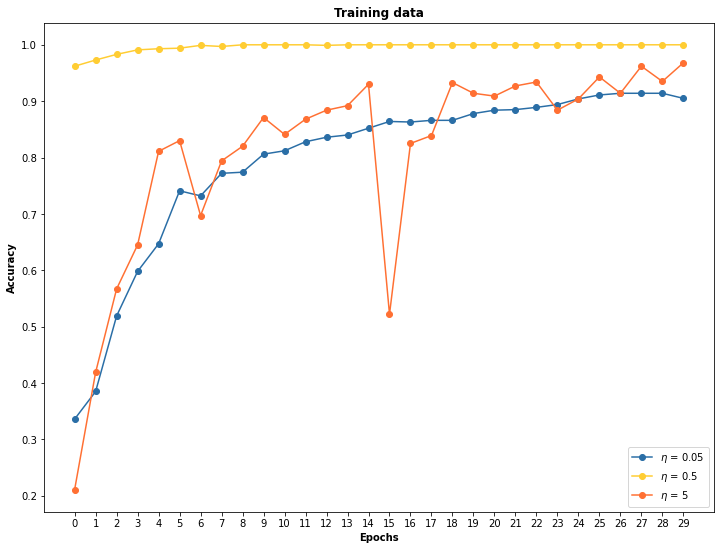

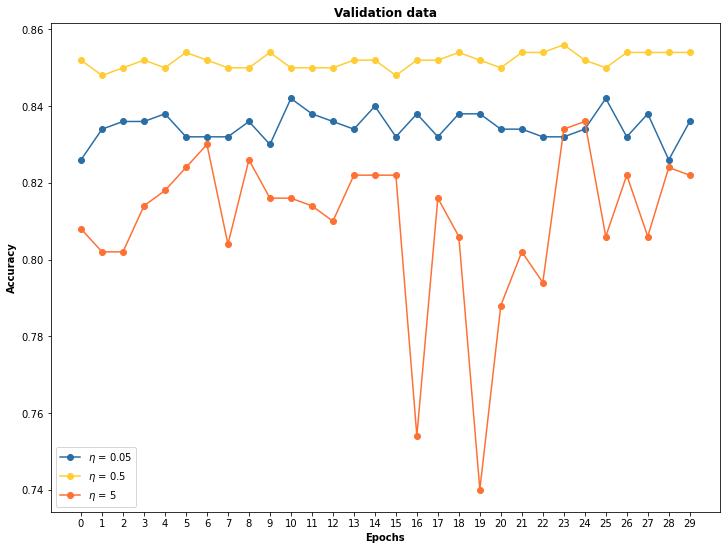

In [416]:
# For computational purposes we decide to reduce the size of the training and validation set. As we are comparing different 
# learning rates, we dont currently care about their absolute performance but mainly about their comparative performance, 
# so in the following we are going to explore the figures rather than the specific accuracy on the training and validation set.
# What we obtain from the followin figures is that for η = 0.05,0.5 the accuracy is almost better both in training and validation set,
# but in the validation set the oscilations are omnipresent, henceforth the credibility of the model accuracy is not stable.
net1 = Network1(sizes = [784,30,10])
results_accuracy_train = []
results_accuracy_valid = []
learning_rates = [0.05,0.5,5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for eta in learning_rates:
    results_accuracy_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = 0,
                                 monitor_evaluation_cost = False,
                                 monitor_training_accuracy = True,
                                 monitor_training_cost = False,
                                 hyper_training_accuracy_plot = True,
                                 hyper_evaluation_accuracy_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_accuracy_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = 0,
                                 monitor_evaluation_accuracy = True,
                                 monitor_training_cost = False,
                                 hyper_training_cost_plot = False,
                                 hyper_evaluation_accuracy_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, eta, color in zip(results_accuracy_train, learning_rates, COLORS):
      ax.plot(np.arange(n_epochs),[x/1000 for x in result],'o-',label = "$\eta$ = "+str(eta),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Accuracy', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, eta, color in zip(results_accuracy_valid, learning_rates, COLORS):
      ax1.plot(np.arange(n_epochs),[x/500 for x in result],'o-',label = "$\eta$ = "+str(eta),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Accuracy', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show()

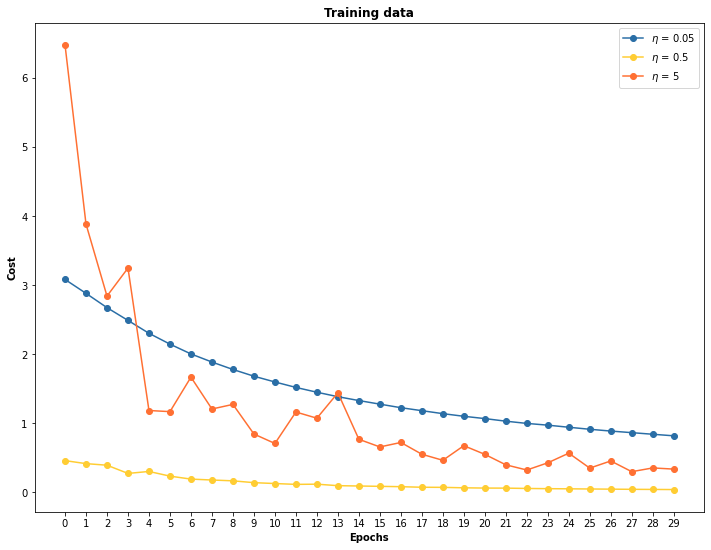

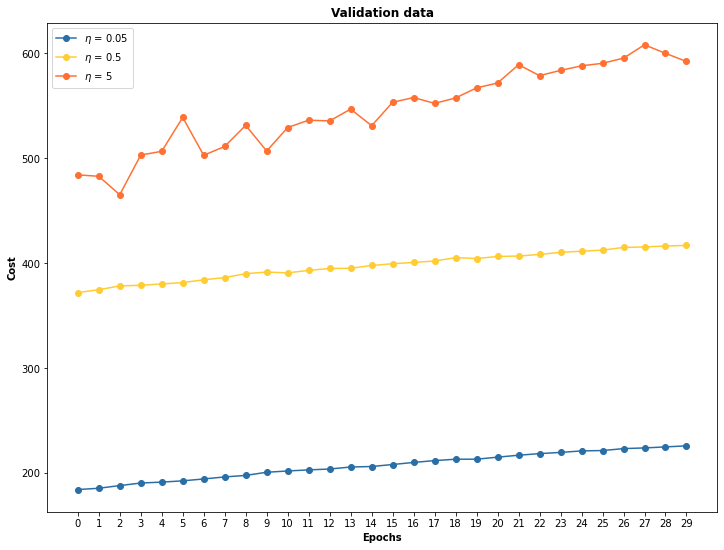

In [380]:
# Let us now generate the respective figures for the cost function. Here we see that η = 0.5 outperforms the other values on 
# the training data, while η = 5 comes second but with many fluctuations indicating that this value may be too large. On the 
# other side, on validation set all figures have increasing trend indicating that the model does not perform in the desired way
# while trying to classify the 'unseen' data.
net1 = Network1(sizes = [784,30,10])
results_cost_train = []
results_cost_valid = []
learning_rates = [0.05,0.5,5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for eta in learning_rates:
    results_cost_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = 0,
                                 monitor_evaluation_cost = False,
                                 monitor_training_cost = True,
                                 hyper_training_cost_plot = True,
                                 hyper_evaluation_cost_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_cost_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = 0,
                                 monitor_evaluation_cost = True,
                                 monitor_training_cost = False,
                                 hyper_training_cost_plot = False,
                                 hyper_evaluation_cost_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, eta, color in zip(results_cost_train, learning_rates, COLORS):
      ax.plot(np.arange(n_epochs),result,'o-',label = "$\eta$ = "+str(eta),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Cost', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, eta, color in zip(results_cost_valid, learning_rates, COLORS):
      ax1.plot(np.arange(n_epochs),result,'o-',label = "$\eta$ = "+str(eta),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Cost', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show()

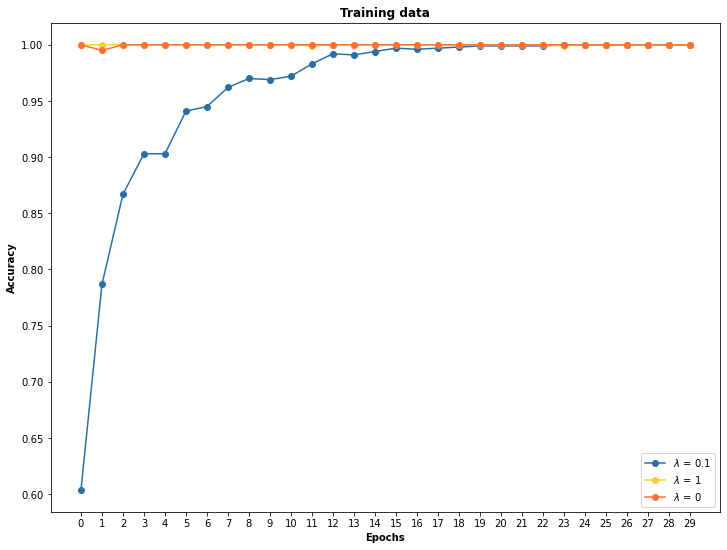

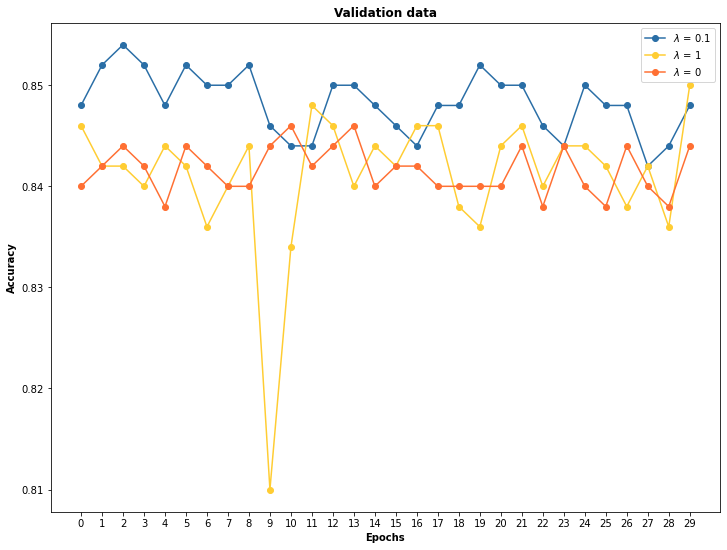

In [471]:
# As in three out of four previous graphs learning rate η = 0.5 has the most desirable outcome, we decide to move forward with 
# this value and now investigate different values for the L2 Regularization term. Firstly, we aim to compare the performnce of
# the model when it is regulalised and when its not. Heuristically, we start by comparing λ = 1 and λ = 0.1 with no regularization
# (i.e λ = 0). So, from the plots below we get that λ = 0 and λ = 1 have (almost)identical high accuracy on the training data, while
# λ = 0.1 reaches this level of accuracy after epoch 18. Now in terms of the validation set, for all different λ value
# there are plenty of oscilations, with λ = 0.1 providing marginally the highest accuracy in time.
net1 = Network1(sizes = [784,30,10])
results_accuracy_train = []
results_accuracy_valid = []
regul_param = [0.1,1,0]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for lmbd in regul_param:
    results_accuracy_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_accuracy = False,
                                 monitor_training_accuracy = True,
                                 hyper_training_accuracy_plot = True,
                                 hyper_evaluation_accuracy_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_accuracy_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_accuracy = True,
                                 monitor_training_accuracy = False,
                                 hyper_training_accuracy_plot = False,
                                 hyper_evaluation_accuracy_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, lmbd, color in zip(results_accuracy_train, regul_param, COLORS):
      ax.plot(np.arange(n_epochs),[x/1000 for x in result],'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Accuracy', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, lmbd, color in zip(results_accuracy_valid, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),[x/500 for x in result],'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Accuracy', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

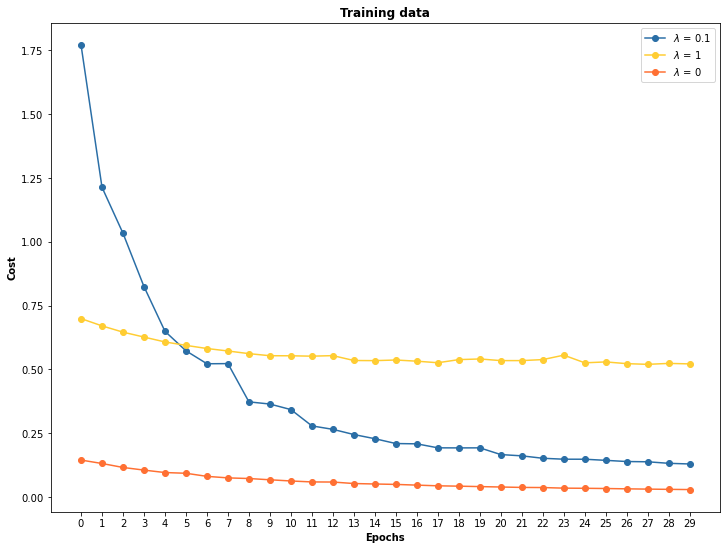

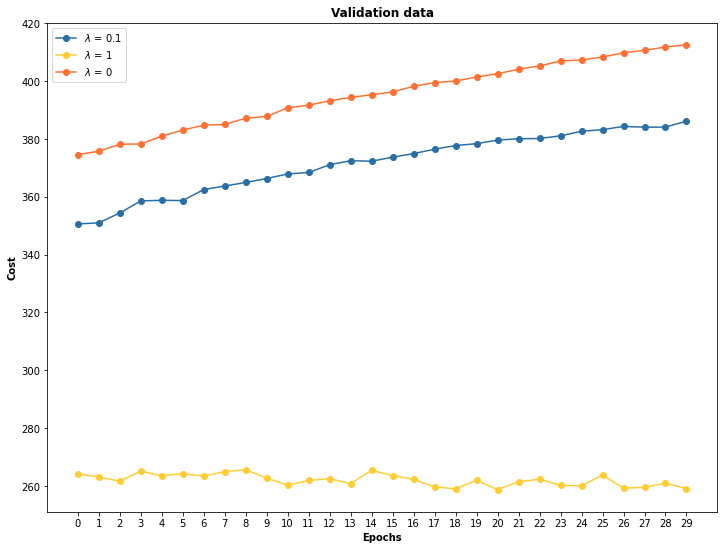

In [472]:
# Lets make the cost plots now.
# We see that the highest value of λ(i.e 1) yields the highest cost on training data and the lowest on the validation data
# and after trying other triples too, the same pattern hold for all of the highest values. This may be the case because greater λ
# values try to keep weights lower than other values, which in turn may lead to better and more controlable weight modifications.
# So, as the weights are getting updated based on the training data, when there is less restriction in their magnitude(i.e lower
# λ values) they can be more well fitted to the seen data, but an opposite pattern holds for the 'unseen' data. However, as in the
# accuracy graphs above the largest λ value was outperformed in both the training and validation set we prefer to continue with 
# a small value and in particular with λ = 0.1. However, the discrepancy between λ =0.1 and no regulaization at all is small, so
# we continue with thse two values and we compare them with values of less magnitude. Note that since we are using a small part 
# of the training and validation dataset the λ value may has to be adjusted accordingly if we increase the number of input values.
net1 = Network1(sizes = [784,30,10])
results_cost_train = []
results_cost_valid = []
regul_param = [0.1,1,0]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for lmbd in regul_param:
    results_cost_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_cost = False,
                                 monitor_training_cost = True,
                                 hyper_training_cost_plot = True,
                                 hyper_evaluation_cost_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_cost_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_cost = True,
                                 monitor_training_cost = False,
                                 hyper_training_cost_plot = False,
                                 hyper_evaluation_cost_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, lmbd, color in zip(results_cost_train, regul_param, COLORS):
      ax.plot(np.arange(n_epochs),result,'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Cost', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, lmbd, color in zip(results_cost_valid, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),result,'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Cost', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

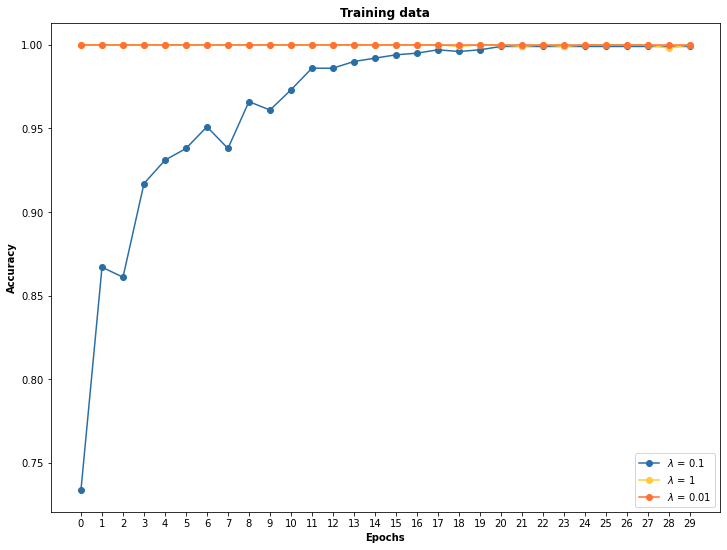

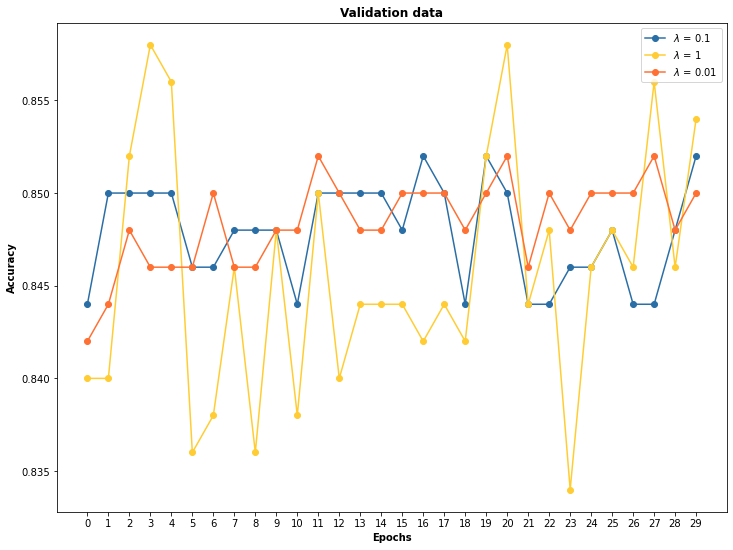

In [473]:
# The new lambda values, i,e λ = 0.01 has equal high accuracy on the training data as λ = 1, while for λ = 0.1 the model is 
# improving along epochs. On the other hand, the accuracy on the validation set shows again many fluctuations with the value
# λ = 1 reaching the highest and the minimum levels and the λ = 0.01 having the less variant and with a sligh increase performance. 
net1 = Network1(sizes = [784,30,10])
results_accuracy_train = []
results_accuracy_valid = []
regul_param = [0.1,1,0.01]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for lmbd in regul_param:
    results_accuracy_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_accuracy = False,
                                 monitor_training_accuracy = True,
                                 hyper_training_accuracy_plot = True,
                                 hyper_evaluation_accuracy_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_accuracy_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_accuracy = True,
                                 monitor_training_accuracy = False,
                                 hyper_training_accuracy_plot = False,
                                 hyper_evaluation_accuracy_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, lmbd, color in zip(results_accuracy_train, regul_param, COLORS):
      ax.plot(np.arange(n_epochs),[x/1000 for x in result],'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Accuracy', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, lmbd, color in zip(results_accuracy_valid, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),[x/500 for x in result],'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Accuracy', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

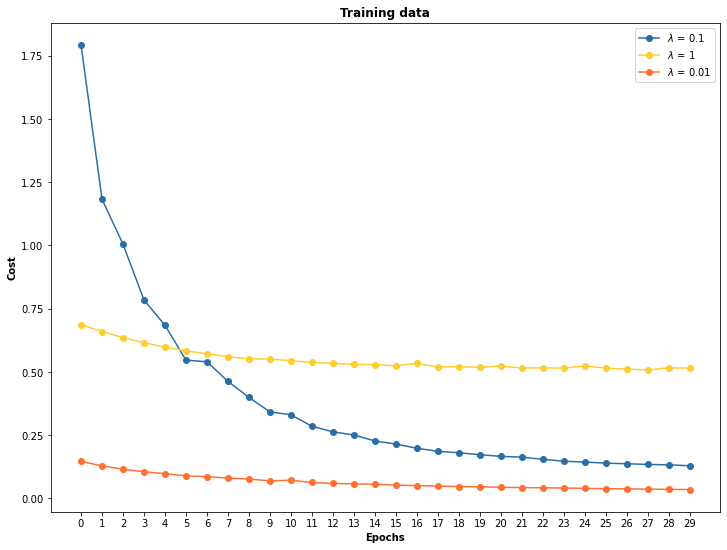

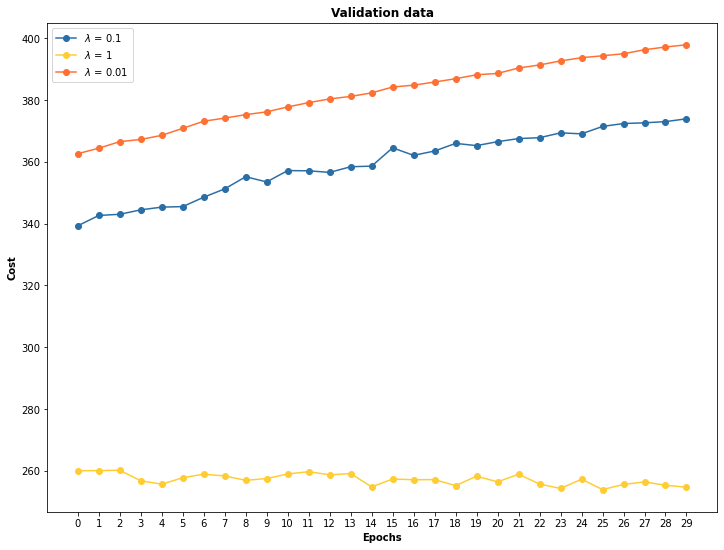

In [474]:
# As regards the cost of the model, again greater λ values are the best on validation set but the worst on the training set, while
# only λ = 0.01 shows some significant learning process, at least on the training data.
net1 = Network1(sizes = [784,30,10])
results_cost_train = []
results_cost_valid = []
regul_param = [0.1,1,0.01]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033']
n_epochs = 30
for lmbd in regul_param:
    results_cost_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_cost = False,
                                 monitor_training_cost = True,
                                 hyper_training_cost_plot = True,
                                 hyper_evaluation_cost_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_cost_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = 0.5, lmbd = lmbd,
                                 monitor_evaluation_cost = True,
                                 monitor_training_cost = False,
                                 hyper_training_cost_plot = False,
                                 hyper_evaluation_cost_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (12,9))
fig1,ax1 = plt.subplots(figsize = (12,9))
for result, lmbd, color in zip(results_cost_train, regul_param, COLORS):
      ax.plot(np.arange(n_epochs),result,'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Cost', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, lmbd, color in zip(results_cost_valid, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),result,'o-',label = "$\lambda$ = "+str(lmbd),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Cost', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

In [8]:
# In the following we consider the whole training and validation set, we adjust λ = 0.1 to this, and we measure the accuracy of this 
# model on the validation set. What we obtain, is that there is no imporvement compared to the accuracy of the model without
# L2 regularization.q
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 30, eta =  0.5, lmbd = 0.1,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = validation_data)

Accuracy on evaluation data-Epoch0: 9439 / 10000
Accuracy on evaluation data-Epoch1: 9509 / 10000
Accuracy on evaluation data-Epoch2: 9496 / 10000
Accuracy on evaluation data-Epoch3: 9535 / 10000
Accuracy on evaluation data-Epoch4: 9584 / 10000
Accuracy on evaluation data-Epoch5: 9570 / 10000
Accuracy on evaluation data-Epoch6: 9598 / 10000
Accuracy on evaluation data-Epoch7: 9569 / 10000
Accuracy on evaluation data-Epoch8: 9504 / 10000
Accuracy on evaluation data-Epoch9: 9620 / 10000
Accuracy on evaluation data-Epoch10: 9552 / 10000
Accuracy on evaluation data-Epoch11: 9600 / 10000
Accuracy on evaluation data-Epoch12: 9609 / 10000
Accuracy on evaluation data-Epoch13: 9613 / 10000
Accuracy on evaluation data-Epoch14: 9566 / 10000
Accuracy on evaluation data-Epoch15: 9598 / 10000
Accuracy on evaluation data-Epoch16: 9569 / 10000
Accuracy on evaluation data-Epoch17: 9599 / 10000
Accuracy on evaluation data-Epoch18: 9584 / 10000
Accuracy on evaluation data-Epoch19: 9589 / 10000
Accuracy o

In [10]:
# We continue with λ = 0.1 but we double the number of epochs as this λ value indicated some accuracy progress throughout epochs
# on the training data. However we see that finally there is no improvement in the accuracy and thus other parameters must be 
# found.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 60, eta =  0.5, lmbd = 0.1,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = validation_data)

Accuracy on evaluation data-Epoch0: 9401 / 10000
Accuracy on evaluation data-Epoch1: 9475 / 10000
Accuracy on evaluation data-Epoch2: 9537 / 10000
Accuracy on evaluation data-Epoch3: 9545 / 10000
Accuracy on evaluation data-Epoch4: 9532 / 10000
Accuracy on evaluation data-Epoch5: 9613 / 10000
Accuracy on evaluation data-Epoch6: 9585 / 10000
Accuracy on evaluation data-Epoch7: 9592 / 10000
Accuracy on evaluation data-Epoch8: 9601 / 10000
Accuracy on evaluation data-Epoch9: 9606 / 10000
Accuracy on evaluation data-Epoch10: 9576 / 10000
Accuracy on evaluation data-Epoch11: 9605 / 10000
Accuracy on evaluation data-Epoch12: 9564 / 10000
Accuracy on evaluation data-Epoch13: 9602 / 10000
Accuracy on evaluation data-Epoch14: 9600 / 10000
Accuracy on evaluation data-Epoch15: 9599 / 10000
Accuracy on evaluation data-Epoch16: 9585 / 10000
Accuracy on evaluation data-Epoch17: 9578 / 10000
Accuracy on evaluation data-Epoch18: 9607 / 10000
Accuracy on evaluation data-Epoch19: 9608 / 10000
Accuracy o

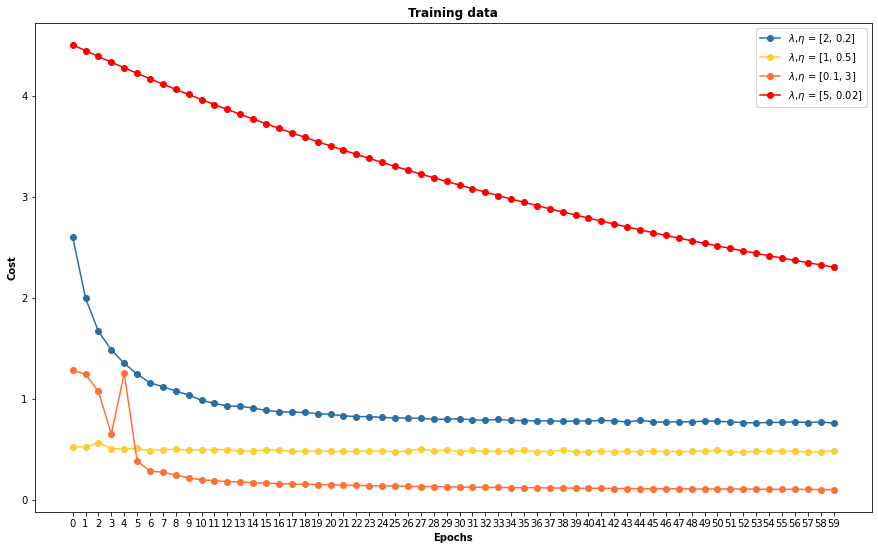

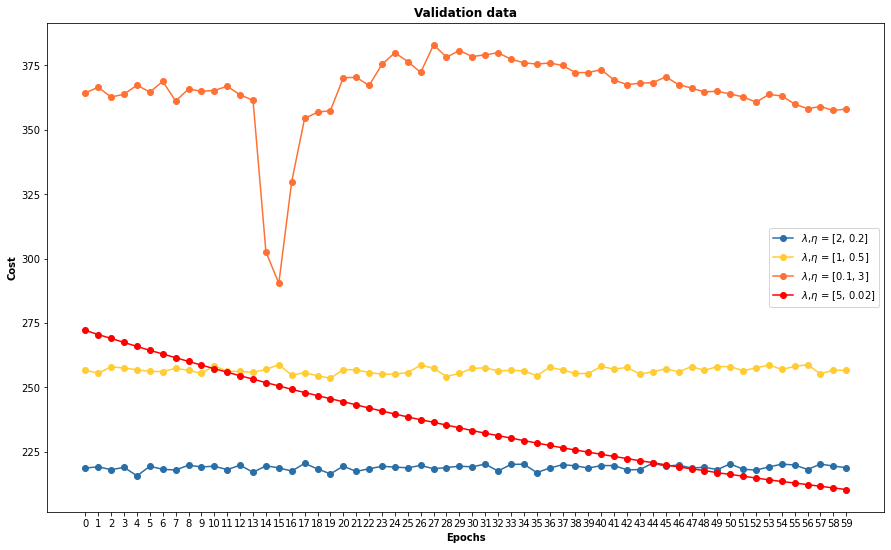

In [12]:
# Now, instead of trying one οf the η and λ each time we decide to monitor their performance simultaneously as follows.  

# We observe that the only combination that showcases some desirable development both on training and validation set through 
# epochs is the (λ,η)=(5,0.02) and it has finally best cost on the validation set. The combination (0.1,3) has the lowest cost
# on the training data but the highest and most abrupt in terms of changes on the validation set.
# We observe that lower or medium η,λ values lead to higher accuracy but greater difference between the model performances on 
# the training and validation set. For very small learning rates there is an increasing trend but lower accuracy
# (always up to the number of epochs)What about high λ and low η?
net1 = Network1(sizes = [784,30,10])
results_cost_train = []
results_cost_valid = []
learn_rates = [0.2,0.5,3,0.02]
regul_param = [2,1,0.1,5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033', 'r']
n_epochs = 60
for eta, lmbd in zip(learn_rates,regul_param):
    results_cost_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = lmbd,
                                 monitor_evaluation_accuracy = False,
                                 monitor_training_cost = True,
                                 hyper_training_cost_plot = True,
                                 hyper_evaluation_accuracy_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_cost_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = lmbd,
                                 monitor_evaluation_accuracy = False,
                                 monitor_evaluation_cost = True,
                                 hyper_training_accuracy_plot = False,
                                 hyper_evaluation_cost_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (15,9))
fig1,ax1 = plt.subplots(figsize = (15,9))
for result, eta,lmbd, color in zip(results_cost_train, learn_rates,regul_param, COLORS):
      ax.plot(np.arange(n_epochs),[x for x in result],'o-',label = "$\lambda$,$\eta$ = "+str([lmbd,eta]),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Cost', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, eta,lmbd, color in zip(results_cost_valid,learn_rates, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),[x for x in result],'o-',label = "$\lambda$,$\eta$ = "+str([lmbd,eta]),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Cost', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

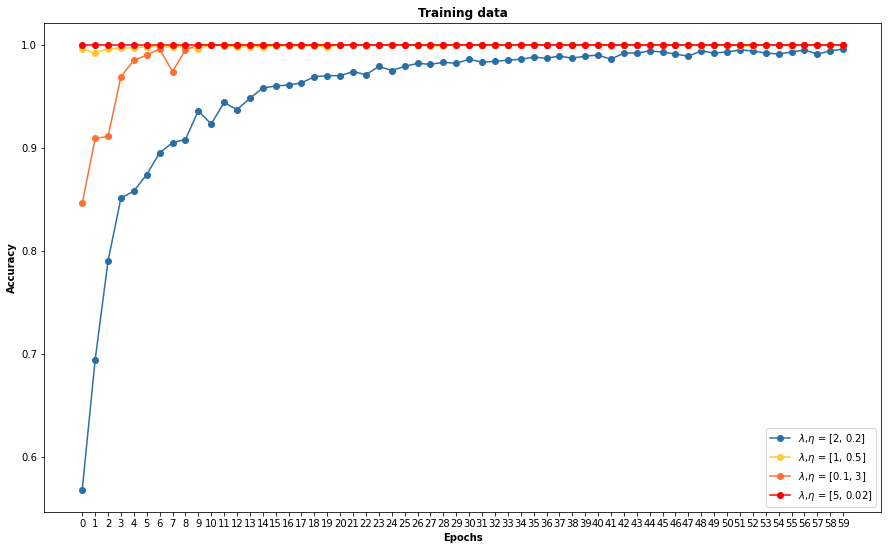

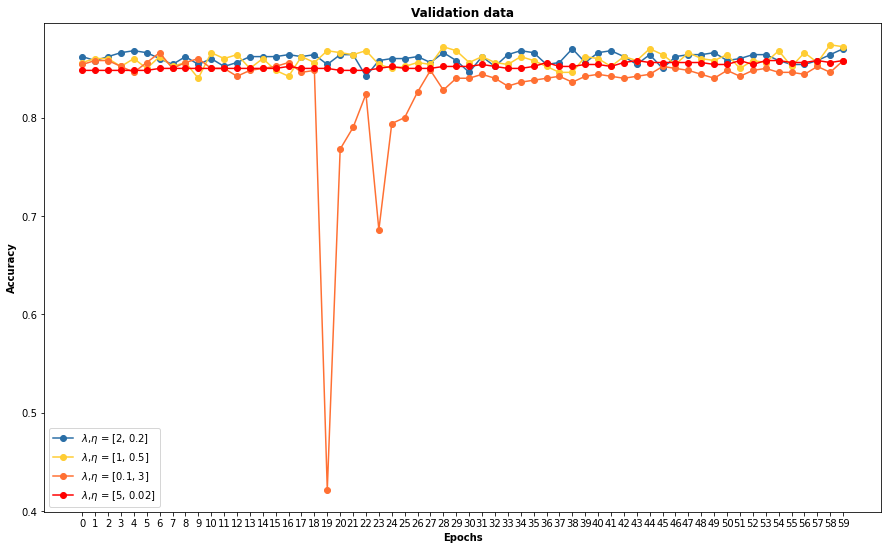

In [16]:
# In the φολλοςινγ, the combination (λ,η) = (2,0.2) demonstrates some gradual increase on the training data while the rest of the 
# combinations reach their highest accuracy from the ωερυ first epochs. Οn the validation set the combination (5,0.02) shows 
# the least variant behaviour but with no increasing disposition.
net1 = Network1(sizes = [784,30,10])
results_accuracy_train = []
results_accuracy_valid = []
learn_rates = [0.2,0.5,3,0.02]
regul_param = [2,1,0.1,5]
COLORS = ['#2A6EA6', '#FFCD33', '#FF7033','r']
n_epochs = 60
for eta, lmbd in zip(learn_rates,regul_param):
    results_accuracy_train.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = lmbd,
                                 monitor_evaluation_accuracy = False,
                                 monitor_training_accuracy = True,
                                 hyper_training_accuracy_plot = True,
                                 hyper_evaluation_accuracy_plot = False,
                                 evaluation_data = validation_data[:500]))
    results_accuracy_valid.append(net1.SGD(training_data[:1000], mini_batch_size = 15, epochs = n_epochs, eta = eta, lmbd = lmbd,
                                 monitor_evaluation_accuracy = True,
                                 monitor_training_accuracy = False,
                                 hyper_training_accuracy_plot = False,
                                 hyper_evaluation_accuracy_plot = True,
                                 evaluation_data = validation_data[:500]))

fig,ax = plt.subplots(figsize = (15,9))
fig1,ax1 = plt.subplots(figsize = (15,9))
for result, eta,lmbd, color in zip(results_accuracy_train, learn_rates,regul_param, COLORS):
      ax.plot(np.arange(n_epochs),[x/1000 for x in result],'o-',label = "$\lambda$,$\eta$ = "+str([lmbd,eta]),color = color)
ax.set_xticks(ticks = list(range(n_epochs)))
ax.set_xticklabels(list(range(n_epochs)))
ax.set_xlabel('Epochs', weight = 'bold')
ax.set_ylabel('Accuracy', weight = 'bold')
ax.set_title('Training data', weight = 'bold')
ax.legend(loc = 0)

for result, eta,lmbd, color in zip(results_accuracy_valid,learn_rates, regul_param, COLORS):
      ax1.plot(np.arange(n_epochs),[x/500 for x in result],'o-',label = "$\lambda$,$\eta$ = "+str([lmbd,eta]),color = color)
ax1.set_xticks(ticks = list(range(n_epochs)))
ax1.set_xticklabels(list(range(n_epochs)))
ax1.set_xlabel('Epochs', weight = 'bold')
ax1.set_ylabel('Accuracy', weight = 'bold')
ax1.set_title('Validation data', weight = 'bold')
ax1.legend(loc = 0)
plt.show() 

In [18]:
# From the above the two combinations that seem to learn along the epochs are the (λ,η) = (5,0.02), (2,0.2) and therefore
# we proceed to get their accuracy level on the validation set, using the aggregate values of the sets. The following values
# for (5,0.02) have a desirable increasing trend in general but of small rate and finally there is no imporvement compared
# to the previous models(including the no regularization one).
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 60, eta =  0.02, lmbd = 5,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = validation_data)

Accuracy on evaluation data-Epoch0: 8728 / 10000
Accuracy on evaluation data-Epoch1: 9026 / 10000
Accuracy on evaluation data-Epoch2: 9126 / 10000
Accuracy on evaluation data-Epoch3: 9177 / 10000
Accuracy on evaluation data-Epoch4: 9239 / 10000
Accuracy on evaluation data-Epoch5: 9272 / 10000
Accuracy on evaluation data-Epoch6: 9301 / 10000
Accuracy on evaluation data-Epoch7: 9332 / 10000
Accuracy on evaluation data-Epoch8: 9338 / 10000
Accuracy on evaluation data-Epoch9: 9377 / 10000
Accuracy on evaluation data-Epoch10: 9394 / 10000
Accuracy on evaluation data-Epoch11: 9412 / 10000
Accuracy on evaluation data-Epoch12: 9444 / 10000
Accuracy on evaluation data-Epoch13: 9448 / 10000
Accuracy on evaluation data-Epoch14: 9456 / 10000
Accuracy on evaluation data-Epoch15: 9468 / 10000
Accuracy on evaluation data-Epoch16: 9479 / 10000
Accuracy on evaluation data-Epoch17: 9488 / 10000
Accuracy on evaluation data-Epoch18: 9501 / 10000
Accuracy on evaluation data-Epoch19: 9503 / 10000
Accuracy o

In [19]:
# Here the combination (2,0.2) ameliorates the performance of the model reaching the rate of 9688/10000 which is better than 
# the 9667/1000 of the model without regularization. However is not keeping improving towards the last epoch.
# Even if we have doubled the number of epochs, this model outperforms the no regularization model within the first 30 epochs
# as well. So we decide to continue with this model in the following step.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 60, eta =  0.2, lmbd = 2,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = validation_data)

Accuracy on evaluation data-Epoch0: 9311 / 10000
Accuracy on evaluation data-Epoch1: 9474 / 10000
Accuracy on evaluation data-Epoch2: 9514 / 10000
Accuracy on evaluation data-Epoch3: 9494 / 10000
Accuracy on evaluation data-Epoch4: 9568 / 10000
Accuracy on evaluation data-Epoch5: 9605 / 10000
Accuracy on evaluation data-Epoch6: 9607 / 10000
Accuracy on evaluation data-Epoch7: 9605 / 10000
Accuracy on evaluation data-Epoch8: 9632 / 10000
Accuracy on evaluation data-Epoch9: 9612 / 10000
Accuracy on evaluation data-Epoch10: 9640 / 10000
Accuracy on evaluation data-Epoch11: 9629 / 10000
Accuracy on evaluation data-Epoch12: 9655 / 10000
Accuracy on evaluation data-Epoch13: 9651 / 10000
Accuracy on evaluation data-Epoch14: 9652 / 10000
Accuracy on evaluation data-Epoch15: 9647 / 10000
Accuracy on evaluation data-Epoch16: 9665 / 10000
Accuracy on evaluation data-Epoch17: 9637 / 10000
Accuracy on evaluation data-Epoch18: 9662 / 10000
Accuracy on evaluation data-Epoch19: 9649 / 10000
Accuracy o

In [20]:
# Let us now check this last model to the test data that we were keeping hidden throughout the whole process.
# It reaches accuracy level of 96,5% and it has a slight rising tendency.

# Here we end the investiagtion of the models parameters. At this stage I want to mention that L1 regularization techniques 
# were used as well, but without any significant success and therefore the details were omitted. We could continue the checking 
# by incorporating the other parameters too(number of layers, neurons per layer, number of epochs, mini batch size), but the scope
# of this project was to build and improve by some standard techniques a neural network.
net = Network1(sizes = [784,30,10], cost = cross_entropy)
net.SGD(training_data, mini_batch_size = 15, epochs = 60, eta =  0.2, lmbd = 2,
            monitor_training_cost = False,
            monitor_training_accuracy =False,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = True,
            evaluation_data = test_data)

Accuracy on evaluation data-Epoch0: 9260 / 10000
Accuracy on evaluation data-Epoch1: 9393 / 10000
Accuracy on evaluation data-Epoch2: 9401 / 10000
Accuracy on evaluation data-Epoch3: 9389 / 10000
Accuracy on evaluation data-Epoch4: 9534 / 10000
Accuracy on evaluation data-Epoch5: 9524 / 10000
Accuracy on evaluation data-Epoch6: 9533 / 10000
Accuracy on evaluation data-Epoch7: 9576 / 10000
Accuracy on evaluation data-Epoch8: 9567 / 10000
Accuracy on evaluation data-Epoch9: 9596 / 10000
Accuracy on evaluation data-Epoch10: 9574 / 10000
Accuracy on evaluation data-Epoch11: 9598 / 10000
Accuracy on evaluation data-Epoch12: 9587 / 10000
Accuracy on evaluation data-Epoch13: 9606 / 10000
Accuracy on evaluation data-Epoch14: 9619 / 10000
Accuracy on evaluation data-Epoch15: 9630 / 10000
Accuracy on evaluation data-Epoch16: 9619 / 10000
Accuracy on evaluation data-Epoch17: 9603 / 10000
Accuracy on evaluation data-Epoch18: 9621 / 10000
Accuracy on evaluation data-Epoch19: 9624 / 10000
Accuracy o

In [ ]:


# References : Neural Network and Deep Learning - Michael Nielsen